In [4]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [5]:
from coin_if import COINWrapper,read_COIN_params

In [6]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [7]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/')

In [8]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [9]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/experimental/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            kk = paradigm_short[paradigm]+str(i)
            opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [10]:
param_names

['sigma_process_noise',
 'prior_mean_retention',
 'prior_precision_retention',
 'prior_precision_drift',
 'alpha_context',
 'rho_context',
 'sigma_motor_noise',
 'alpha_cue']

In [11]:
opt_data

{0: {'MSE': {'x': [0.1234,
    0.8827,
    0.018,
    0.0076,
    120.0,
    0.2699,
    0.0901,
    nan]}},
 1: {'MSE': {'x': [0.1441,
    0.9121,
    0.0003,
    0.0087,
    380.0,
    0.1285,
    0.0804,
    nan]}},
 2: {'MSE': {'x': [0.1119, 0.9466, 6e-05, 0.0075, 230.0, 0.007, 0.0781, nan]}},
 3: {'MSE': {'x': [0.1172, 0.8578, 0.012, 0.0059, 12.0, 0.0477, 0.0883, nan]}},
 4: {'MSE': {'x': [0.0705,
    0.946,
    0.0013,
    0.0051,
    10000000.0,
    0.3911,
    0.0715,
    nan]}},
 5: {'MSE': {'x': [0.0559, 0.9643, 0.003, 0.0049, 29.0, 0.0044, 0.0966, nan]}},
 6: {'MSE': {'x': [0.0926,
    0.9422,
    1.6e-05,
    0.0033,
    3700000.0,
    0.0003,
    0.0936,
    nan]}},
 7: {'MSE': {'x': [0.099, 0.8405, 0.0023, 0.0071, 160.0, 0.5336, 0.1, nan]}},
 8: {'MSE': {'x': [0.1591, 0.7996, 0.69, 0.00014, 31.0, 0.3297, 0.0641, nan]}},
 9: {'MSE': {'x': [0.126,
    0.9488,
    0.00081,
    0.0062,
    22.0,
    0.0869,
    0.0661,
    nan]}},
 10: {'MSE': {'x': [0.0331,
    0.9308,
    0

In [12]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict()        

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [13]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [14]:
pooling_fun = 'MSE'

In [15]:
outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.49s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.70s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


Text(0.5, 1.0, 'subjects -->>1')

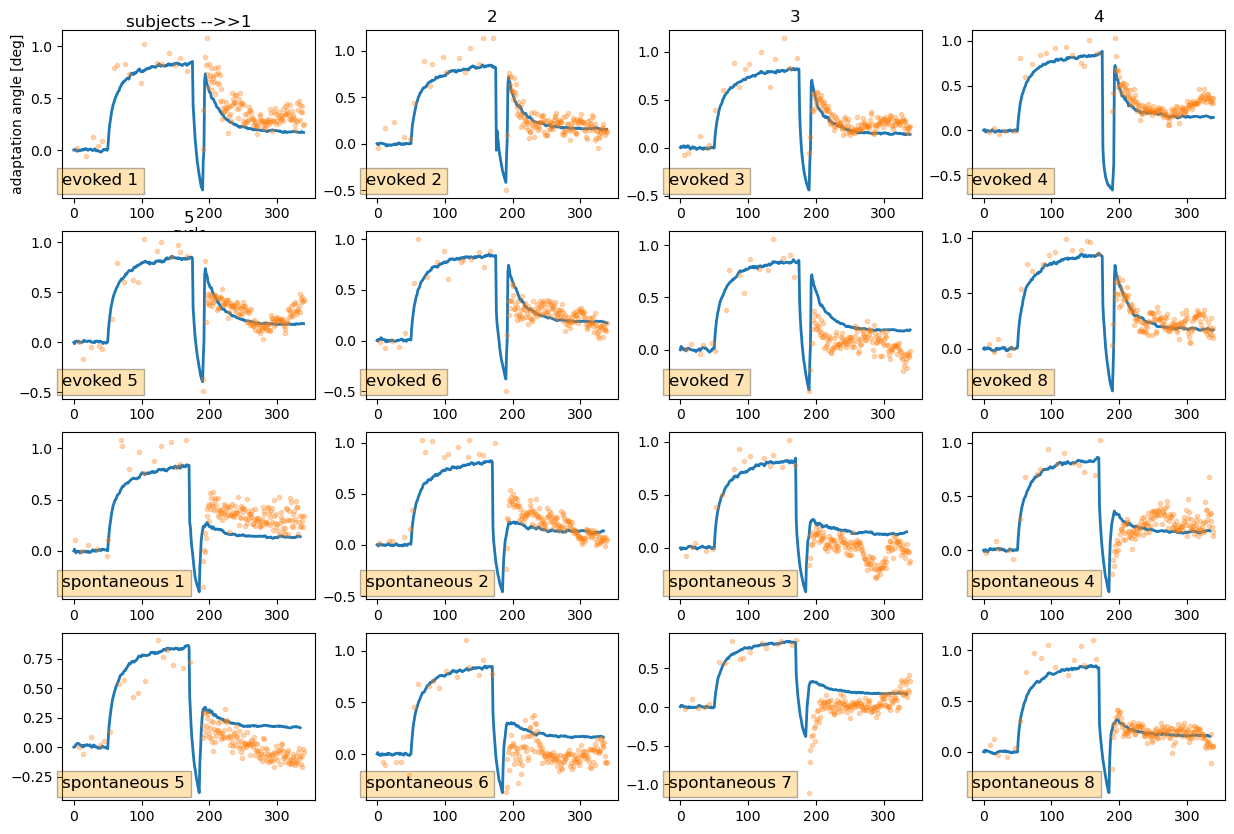

In [16]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [19]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)
data_ = np.array([data[k] for k in opt_data])

/tmp/ipykernel_2839840/546502521.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outs_ = np.array(outs_)


In [22]:
outs_.shape

(16,)

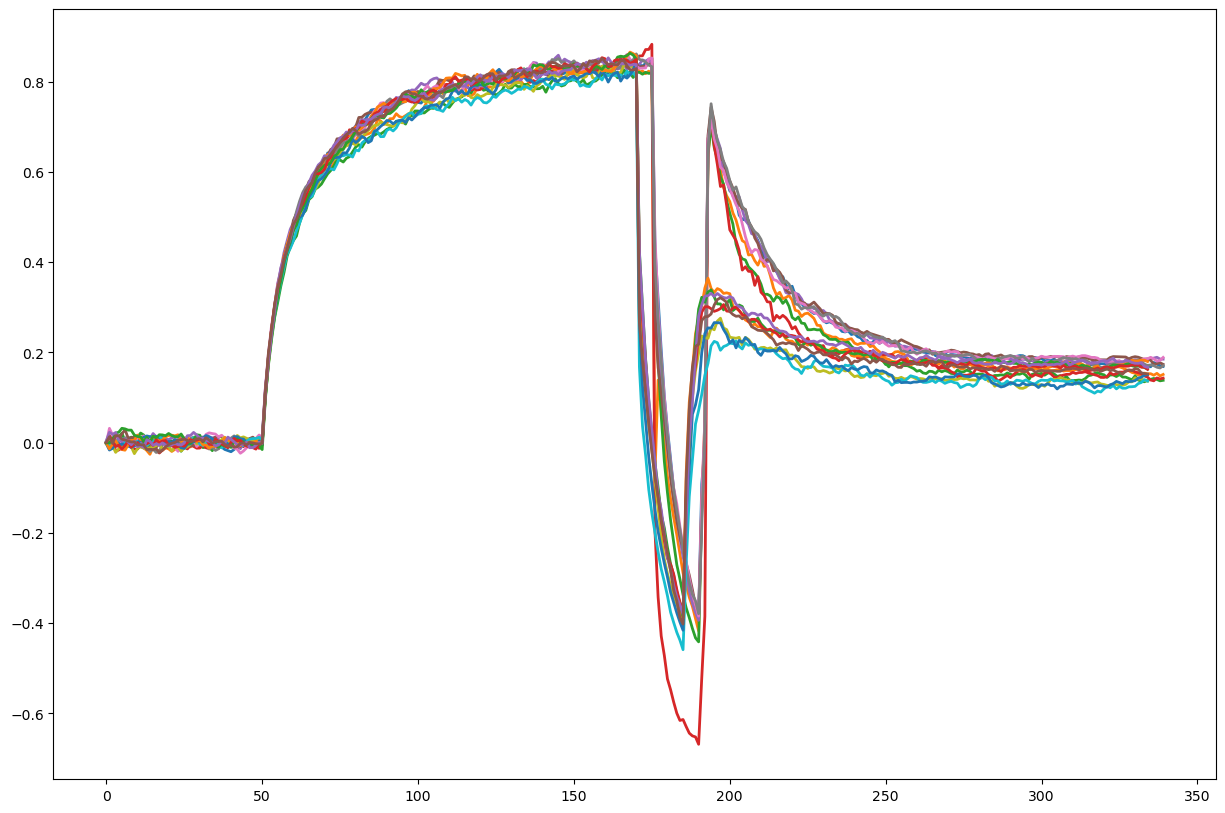

In [27]:
plt.figure(figsize=(15,10))
for k in opt_data:
    # plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)

In [23]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


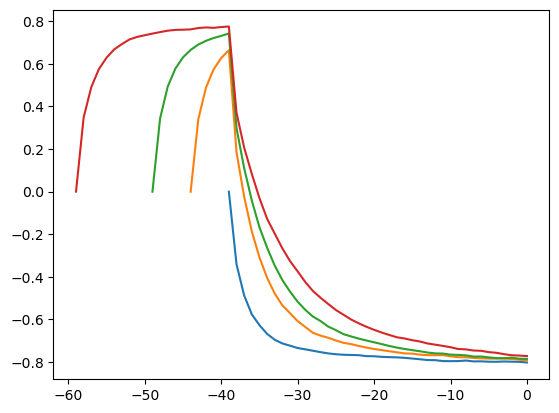

In [24]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [25]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


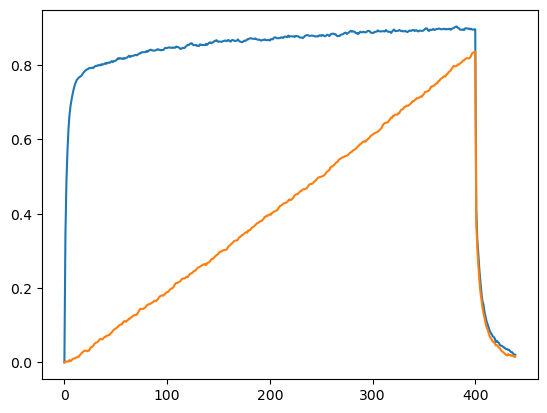

In [26]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))